In [72]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as Keras

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset_path = "data"

config = {
    "batch_size": 32,
    "image_size": 256,
    "n_channels": 3,
    "shuffle": True
}

In [3]:
dataset = Keras.preprocessing.image_dataset_from_directory(
    directory=dataset_path,
    image_size=(config["image_size"], config["image_size"]),
    batch_size=config["batch_size"],
    shuffle=config["shuffle"],
)

Found 20638 files belonging to 15 classes.


In [4]:
# size of dataset = num_files(20638) / batch_size(32) = 645 
len(dataset)

645

In [5]:
class_names = dataset.class_names

In [6]:
len(class_names), class_names

(15,
 ['Pepper__bell___Bacterial_spot',
  'Pepper__bell___healthy',
  'Potato___Early_blight',
  'Potato___Late_blight',
  'Potato___healthy',
  'Tomato_Bacterial_spot',
  'Tomato_Early_blight',
  'Tomato_Late_blight',
  'Tomato_Leaf_Mold',
  'Tomato_Septoria_leaf_spot',
  'Tomato_Spider_mites_Two_spotted_spider_mite',
  'Tomato__Target_Spot',
  'Tomato__Tomato_YellowLeaf__Curl_Virus',
  'Tomato__Tomato_mosaic_virus',
  'Tomato_healthy'])

In [7]:
VIZ_BATCH_INDEX = 1
VIZ_SAMPLES_COUNT = 12

In [8]:
for image_batch, label_batch in dataset.take(VIZ_BATCH_INDEX):
    print(type(image_batch), image_batch.shape)
    print(type(label_batch), label_batch.numpy())

<class 'tensorflow.python.framework.ops.EagerTensor'> (32, 256, 256, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'> [14 14 12  9  5  7 12  5  3 11 12  9  5  1 14  9 14  8  1  5  0  9  7  9
  0  0 12  5 13  5 12 12]


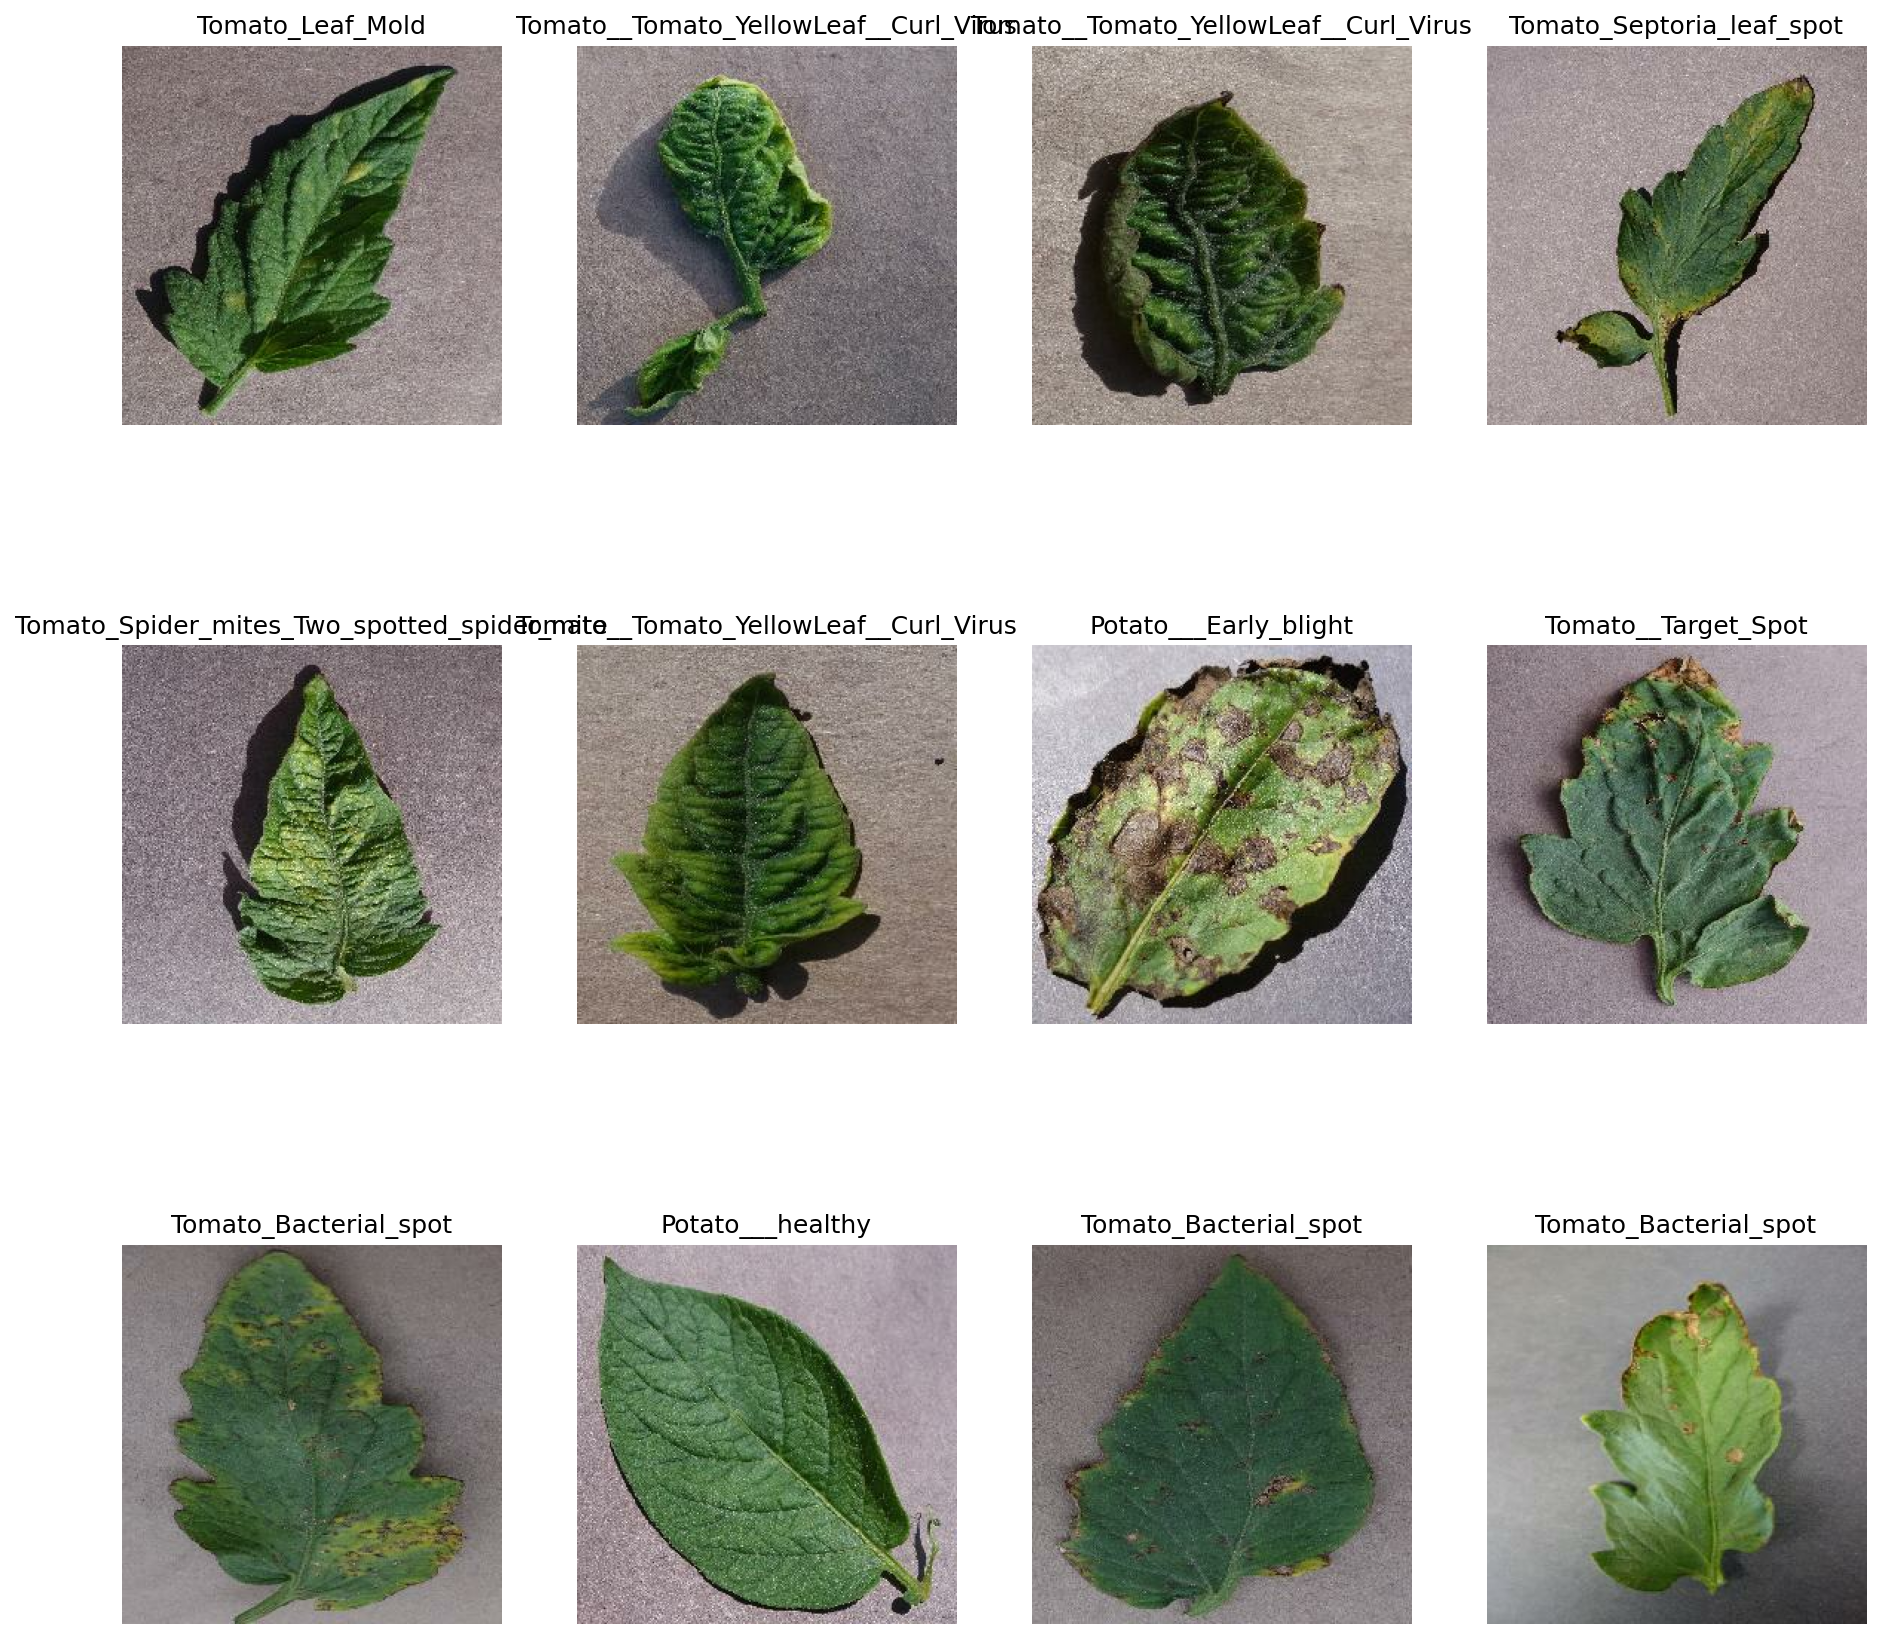

In [9]:
plt.figure(figsize=(15, 15), dpi=150)
for image_batch, label_batch in dataset.take(VIZ_BATCH_INDEX):
    for i in range(VIZ_SAMPLES_COUNT):
        ax = plt.subplot(3, int(VIZ_SAMPLES_COUNT/3), i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [40]:
train_config = {
    "epochs": 30,
    "train_split": 0.8,
    "test_split": 0.1,
    "shuffle": True,
    "early_stopping_patience": 8,
    "lr_sch_round": 12
}

In [11]:
def split_dataset(dataset, train_split, test_split, shuffle=False, shuffle_size=10000):
    ds_len = len(dataset)
    
    if shuffle:
        ds = dataset.shuffle(shuffle_size, seed=10)
    
    train_size = int(ds_len * train_split)
    test_size = int(ds_len * test_split)

    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size).take(test_size)
    val_ds = ds.skip(train_size).skip(test_size)
    
    return train_ds, test_ds, val_ds

In [12]:
train_ds, test_ds, val_ds = split_dataset(
    dataset, 
    train_config["train_split"],
    train_config["test_split"], 
    shuffle=train_config["shuffle"]
)

print(f"...Train set: {len(train_ds)}")
print(f"...Val set: {len(val_ds)}")
print(f"...Test set: {len(test_ds)}")

...Train set: 516
...Val set: 65
...Test set: 64


In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [14]:
INPUT_SHAPE = (config["batch_size"], config["image_size"], config["image_size"], config["n_channels"])
N_CLASSES = len(class_names)

In [42]:
Resize_rescale = Keras.Sequential([
    Keras.layers.Resizing(INPUT_SHAPE[1], INPUT_SHAPE[2]),
    Keras.layers.Rescaling(scale=1./255),
])

In [43]:
Augmentation = Keras.Sequential([
    Keras.layers.RandomFlip(),
    Keras.layers.RandomRotation(factor=0.2),
])

In [44]:
model = Keras.Sequential([
    Resize_rescale,
    Augmentation,
    Keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation=tf.nn.relu, input_shape=INPUT_SHAPE),
    Keras.layers.MaxPool2D(pool_size=(2, 2)),
    Keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu),
    Keras.layers.MaxPool2D(pool_size=(2, 2)),
    Keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu),
    Keras.layers.MaxPool2D(pool_size=(2, 2)),
    Keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu),
    Keras.layers.MaxPool2D(pool_size=(2, 2)),
    Keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
    Keras.layers.MaxPool2D(pool_size=(2, 2)),
    Keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
    Keras.layers.MaxPool2D(pool_size=(2, 2)),
    Keras.layers.Flatten(),
    Keras.layers.Dense(units=256, activation=tf.nn.relu),
    Keras.layers.Dropout(0.5),
    Keras.layers.Dense(units=256, activation=tf.nn.relu),
    Keras.layers.Dropout(0.2),
    Keras.layers.Dense(units=N_CLASSES, activation=tf.nn.softmax)
])

In [45]:
model.build(input_shape=INPUT_SHAPE)

In [46]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_10 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_29 (Conv2D)          (32, 252, 252, 64)        4864      
                                                                 
 max_pooling2d_29 (MaxPoolin  (32, 126, 126, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (32, 124, 124, 128)       73856     
                                                                 
 max_pooling2d_30 (MaxPoolin  (32, 62, 62, 128)        0         
 g2D)                                                

In [47]:
model.compile(
    optimizer=Keras.optimizers.Adam(learning_rate=1e-3),
    loss=Keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [48]:
callbacks = []

early_stopping = Keras.callbacks.EarlyStopping(monitor="val_loss", patience=train_config["early_stopping_patience"])
callbacks.append(early_stopping)

def lr_sch(epoch, lr):
    if epoch < train_config["lr_sch_round"] :
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = Keras.callbacks.LearningRateScheduler(lr_sch)
callbacks.append(lr_scheduler)

checkpoint_path = "tmp/checkpoints-02"
checkpoint = Keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)
callbacks.append(checkpoint)

In [49]:
tf.get_logger().setLevel('ERROR')
history = model.fit(
    train_ds, 
    batch_size=config["batch_size"], 
    epochs=train_config["epochs"], 
    validation_data=val_ds, 
    callbacks=callbacks
).history

Epoch 1/30
516/516 [==============================] - 153s 291ms/step - loss: 2.2648 - accuracy: 0.2552 - val_loss: 1.8233 - val_accuracy: 0.4183 - lr: 0.0010
Epoch 2/30
516/516 [==============================] - 129s 251ms/step - loss: 1.6569 - accuracy: 0.4577 - val_loss: 1.7588 - val_accuracy: 0.4370 - lr: 0.0010
Epoch 3/30
516/516 [==============================] - 128s 247ms/step - loss: 1.2761 - accuracy: 0.5729 - val_loss: 1.0813 - val_accuracy: 0.6413 - lr: 0.0010
Epoch 4/30
516/516 [==============================] - 128s 249ms/step - loss: 1.0408 - accuracy: 0.6517 - val_loss: 0.7893 - val_accuracy: 0.7264 - lr: 0.0010
Epoch 5/30
516/516 [==============================] - 126s 243ms/step - loss: 0.8612 - accuracy: 0.7090 - val_loss: 0.6297 - val_accuracy: 0.7880 - lr: 0.0010
Epoch 6/30
516/516 [==============================] - 127s 246ms/step - loss: 0.7661 - accuracy: 0.7349 - val_loss: 0.6181 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 7/30
516/516 [==========================

Text(0.5, 1.0, 'Training Validation Loss')

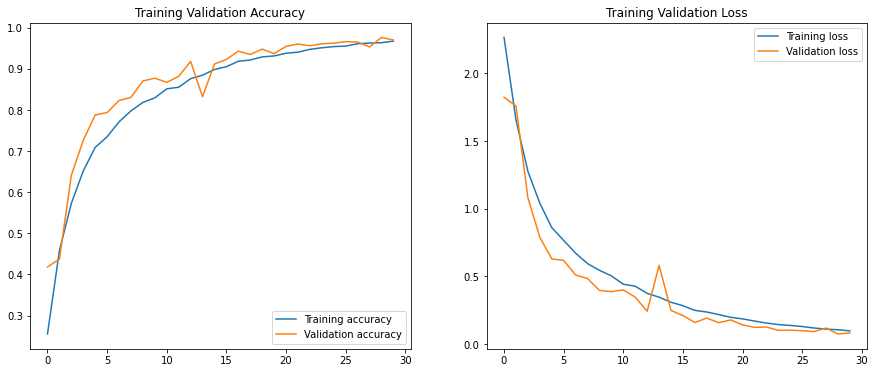

In [50]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(history["accuracy"])), history["accuracy"], label="Training accuracy")
plt.plot(range(len(history["val_accuracy"])), history["val_accuracy"], label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training Validation Accuracy")


plt.subplot(1, 2, 2)
plt.plot(range(len(history["loss"])), history["loss"], label="Training loss")
plt.plot(range(len(history["val_loss"])), history["val_loss"], label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training Validation Loss")

In [52]:
score = model.evaluate(test_ds)

score

64/64 [==============================] - 31s 57ms/step - loss: 0.0838 - accuracy: 0.9727


[0.08378415554761887, 0.97265625]

In [67]:
def predict(model, image, class_names=None):
    image_arr = Keras.preprocessing.image.img_to_array(image)
    image_batch = tf.expand_dims(image_arr, 0)
    predictions = model.predict(image_batch)
    predicted_output = tf.argmax(predictions[0])
    if class_names is not None:
        predicted_output = class_names[tf.argmax(predictions[0])]
    confidence_score = round(100 * predictions[0][predicted_output], 2)
    return predicted_output, confidence_score

In [68]:
def show_predictions(dataset, model, batch_num, n_images, class_names):
    for image_batch, label_batch in dataset.take(batch_num):
        for i in range(n_images):
            plt.subplot(int(n_images/3), 3, i + 1)
            pred, confi = predict(model, image_batch[i].numpy())
            if type(pred) == "string":
                pred_class = pred
            else:
                pred_class = class_names[pred]
            actual_class = class_names[label_batch[i].numpy()]
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(f"Actual: {actual_class} \n Predicted: {pred_class} \n Confidence: {confi}%")
            plt.axis("off")

1/1 [==============================] - 0s 18ms/step


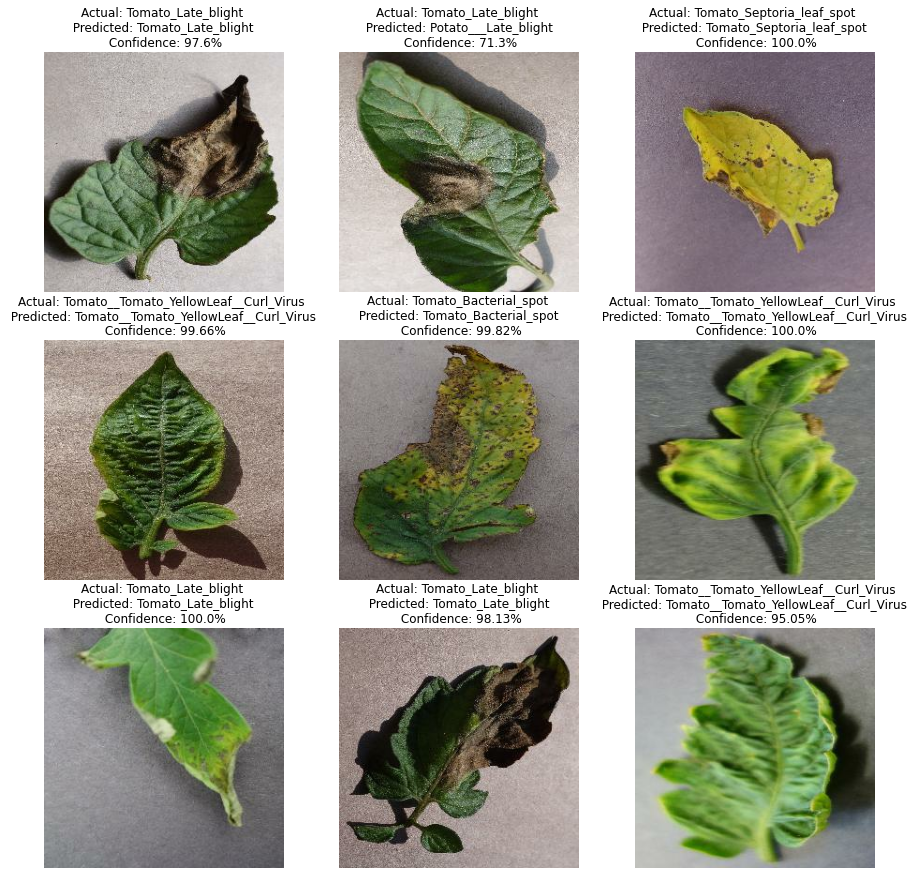

In [69]:
plt.figure(figsize=(15, 15))
show_predictions(test_ds, model, batch_num=1, n_images=9, class_names=class_names)

In [71]:
model_version = max([int(i) for i in os.listdir("models")]) + 1
model.save(f"models/{model_version}")

In [74]:
class_names_df = pd.DataFrame(class_names, columns=["labels"])

class_names_df.to_csv("assets/class_names.csv")